# Reinforcement Learning with Atari Breakout

**Syed Ali Haider**

This notebook explores and implements Reinforcement Learning techniques using the Atari Breakout environment within the Gymnasium framework. It leverages Proximal Policy Optimization (PPO) to train an agent capable of playing the game.

## Environment Setup

This notebook utilizes the Gymnasium framework for the Atari Breakout environment and Stable Baselines3 for implementing the PPO agent. The following libraries are required:

*   Gymnasium
*   Stable Baselines3
*   rltools (custom utilities)

Refer to the code cells below for installation and setup instructions.

## Dependency Installation

The following code cell installs the necessary libraries for this notebook.

In [ ]:
%%capture
!pip install swig
!pip install gymnasium[box2d]==0.28.1
!pip install "stable-baselines3[extra]==2.0.0"
!rm rltools -r
!git clone https://github.com/drbeane/rltools.git  #credit Dr.Robbie Beane
!git clone https://github.com/drbeane/rl_models.git

## Import Statements

This cell contains all necessary import statements for this notebook.

In [ ]:
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from rltools.utils import RandomAgent, SB3Agent
from rltools.utils import create_gif, evaluate, sb3_evaluation_curves

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

import warnings
warnings.filterwarnings('ignore')

# Part 1 - Exploring Breakout Environment

This section explores the Atari Breakout environment using the Gymnasium framework. A Proximal Policy Optimization (PPO) agent will be trained on this environment in the subsequent section.

For detailed information about the Breakout environment, please refer to the Gymnasium documentation.

## 1.A - Environment Initialization

This section initializes the Atari Breakout environment using the `BreakoutNoFrameskip-v4` version. This provides a standard, unprocessed representation of the environment. The initial state of the environment is rendered below.

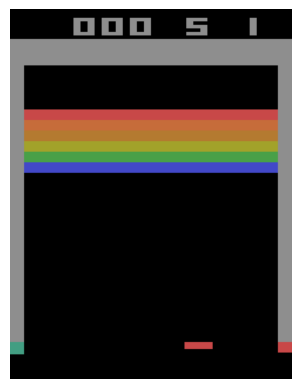

In [ ]:
envA = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")

state,info = envA.reset(seed = 1)
plt.imshow(envA.render())
plt.axis('off')
plt.show()


## 1.B - Action and Observation Space Analysis

This section analyzes the action and observation space of the Breakout environment. The `shape` attribute of the `observation_space` reveals the size of the state arrays, while the `n` attribute of the `action_space` indicates the number of available actions.

In [ ]:
print(envA.observation_space.shape)
print(envA.action_space.n)

(210, 160, 3)
4


## 1.C - Baseline Performance: Random Agent

This section establishes a baseline performance using a random agent. The agent interacts with the environment for a set number of episodes, and its performance is evaluated using a specified discount factor (`gamma`).

In [ ]:
agentRa = RandomAgent(envA, seed = 1)
evaluate(env=envA, agent=agentRa,gamma=1.0,episodes=50,seed=1, max_steps=2000)

Mean Return:    1.2
StdDev Return:  1.3115
Mean Length:    682.1
StdDev Length:  211.2406


{'mean_return': 1.2,
 'stdev_return': 1.3114877048604001,
 'mean_length': 682.1,
 'stdev_length': 211.2405500844949}

## 1.D - Random Agent Episode Visualization

This section visualizes a sample episode generated by the random agent. The episode is rendered as a GIF to illustrate the agent's behavior.

615 steps completed.
Cumulative reward: 1.0


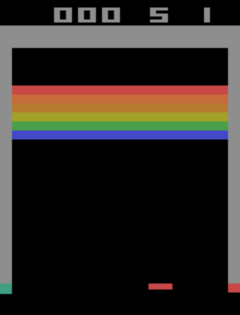

In [ ]:
randomPong = create_gif(envA, agentRa, max_steps=2000, seed=1, folder='gifs', filename='randompong', scale = 1.5)

# Part 2 - Training a PPO Agent

In this section, a Proximal Policy Optimization (PPO) agent is trained on the Breakout environment. The primary objective is to train an agent that demonstrates the ability to react to the ball, even if it doesn't achieve a high score. Achieving high performance on this environment can require significant training time, but this section focuses on demonstrating basic competency.

## 2.A - Environment Creation

This section establishes the environments for training, evaluation, and testing the PPO agent. Three vectorized, processed instances of the Breakout environment are created using `make_atari_env()`, with specific configurations for each purpose. The training and evaluation environments utilize eight environments (`n_envs=8`), while the testing environment uses a single environment (`n_envs=1`). All environments are initialized with a seed of 0 (`seed=0`) for reproducibility. The testing environment further incorporates the original game's reward structure and life-loss behavior through `wrapper_kwargs`. Finally, `VecFrameStack()` is employed to create framestacked versions of each environment with a stack size of 4 (`n_stack=4`).

In [ ]:
atari_base= make_atari_env(env_id='BreakoutNoFrameskip-v4', n_envs=8, seed=0)
atari_eval= make_atari_env(env_id='BreakoutNoFrameskip-v4', n_envs=8, seed=0)
atari_test= make_atari_env(env_id='BreakoutNoFrameskip-v4', n_envs=1, seed=0,wrapper_kwargs={'clip_reward':False, 'terminal_on_life_loss':False})
fs_base = VecFrameStack(atari_base, n_stack=4)
fs_eval = VecFrameStack(atari_eval, n_stack=4)
fs_test = VecFrameStack(atari_test, n_stack=4)
print(fs_test.observation_space.shape)
print(fs_test.action_space.n)

(84, 84, 4)
4


## 2.B - Evaluation Callback Implementation

An `EvalCallback` object is implemented to monitor the agent's performance during training. This callback utilizes the framestacked evaluation environment and triggers an evaluation every 1000 time steps. Each evaluation involves 10 episodes, and warnings are suppressed (`warn=False`).

In [ ]:
if os.path.exists('atari_evaluation/') : shutil.rmtree('atari_evaluation/')
atari_eval_callback = EvalCallback(
    fs_eval, best_model_save_path="atari_evaluation/", log_path="atari_evaluation/",
    n_eval_episodes=10, eval_freq=1000, warn=False)

## 2.C - PPO Model Training

This section details the construction and training of the PPO agent. A linear scheduler is employed for the learning rate, and the PPO model is configured with specific parameters. The agent is trained using the framestacked training environment and monitored using the evaluation callback. This training process typically takes 15-20 minutes.

Note: The default parameters may result in an agent with modest performance, achieving a mean score of around 20 during evaluation. While achieving higher scores is possible with parameter adjustments, this section focuses on demonstrating basic competency.

In [ ]:
%%time

def linear_schedule(initial_lr, final_lr):
    def sched_func(progress_remaining):
        return final_lr + progress_remaining * (initial_lr - final_lr)
    return sched_func

model = PPO(
    env = fs_base,
    policy = "CnnPolicy",
    n_steps = 128,
    n_epochs = 4,
    batch_size = 256,
    learning_rate = linear_schedule(9e-4, 5e-4),
    clip_range = 0.4,
    vf_coef = 0.5,
    ent_coef = 0.01,

    verbose=0,
    seed=1,
)

model = model.learn(total_timesteps=200000, progress_bar=False, callback=atari_eval_callback)

Eval num_timesteps=8000, episode_reward=0.00 +/- 0.00
Episode length: 530.50 +/- 8.27
New best mean reward!
Eval num_timesteps=16000, episode_reward=4.90 +/- 4.16
Episode length: 1126.00 +/- 507.41
New best mean reward!
Eval num_timesteps=24000, episode_reward=2.60 +/- 3.10
Episode length: 920.30 +/- 429.06
Eval num_timesteps=32000, episode_reward=4.60 +/- 5.68
Episode length: 1102.50 +/- 671.21
Eval num_timesteps=40000, episode_reward=6.70 +/- 5.83
Episode length: 1398.10 +/- 756.47
New best mean reward!
Eval num_timesteps=48000, episode_reward=6.60 +/- 6.92
Episode length: 12043.60 +/- 31993.36
Eval num_timesteps=56000, episode_reward=7.40 +/- 4.80
Episode length: 1507.80 +/- 579.64
New best mean reward!
Eval num_timesteps=64000, episode_reward=11.10 +/- 4.70
Episode length: 1763.50 +/- 541.60
New best mean reward!
Eval num_timesteps=72000, episode_reward=6.10 +/- 2.43
Episode length: 1428.60 +/- 368.05
Eval num_timesteps=80000, episode_reward=7.40 +/- 3.47
Episode length: 1407.80 +/

## 2.D - Evaluation Results Visualization

This section visualizes the evaluation results of the trained PPO agent using the `sb3_evaluation_curves()` function. The generated plots illustrate the progression of scores achieved during training on the evaluation environment.

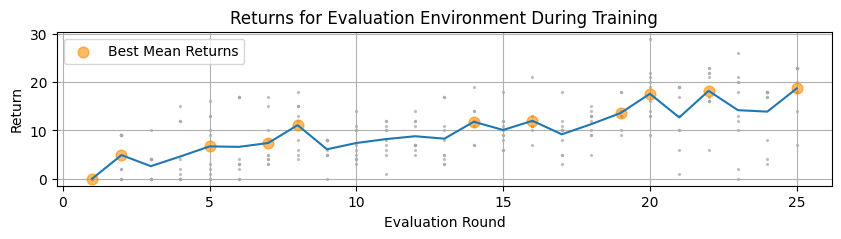

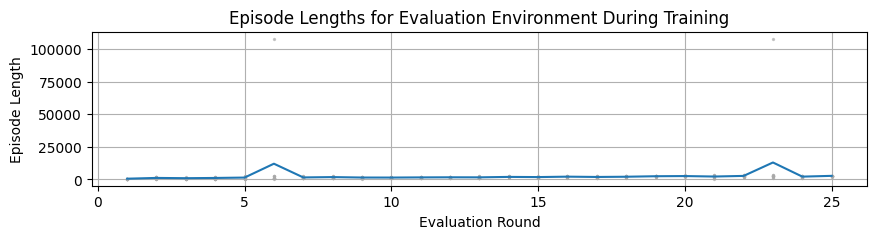

In [ ]:
sb3_evaluation_curves(path='atari_evaluation/')

## 2.E - Best Model Evaluation

This section evaluates the performance of the best-trained PPO agent on the test environment. The best model is loaded, and its performance is assessed using the `evaluate()` function.

In [ ]:
best_model = PPO.load('atari_evaluation/best_model.zip', env=fs_test)
pongBest = SB3Agent(best_model, deterministic=True, normalizer=None)
evaluate(fs_test, pongBest, gamma=1.0, episodes=20, max_steps=2000, seed=1)

Mean Return:    17.1
StdDev Return:  7.8543
Mean Length:    571.65
StdDev Length:  206.3469


{'mean_return': 17.1,
 'stdev_return': 7.854298186343577,
 'mean_length': 571.65,
 'stdev_length': 206.34686210359487}

## 2.F - Trained Agent Episode Visualization

This section visualizes a sample episode generated by the trained PPO agent. The episode is rendered as a GIF to showcase the agent's learned behavior.

427 steps completed.
Cumulative reward: 16.0


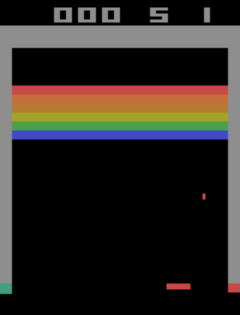

In [ ]:
best = create_gif(fs_test, pongBest, max_steps=2000, seed=20, folder='gifs', filename='best', scale = 1.5)

# Part 3 - Pretrained Model

In this part , we loaded and evaluated a model that was previously trained for 5 million time steps (and several hours) on the Breakout environment. This is to provide a sense as to what is possible if we allowed the model to train longer.

## 3.A - Load and Evaluated the Model

The model for Part 3 is stored in the following file on the VM for this notebook:

`/content/rl_models/breakout/breakout_ppo_final.zip`



In [ ]:
storedmodel = PPO.load('/content/rl_models/breakout/breakout_ppo_final.zip', env=fs_test)
beststoredmodel = SB3Agent(storedmodel)
evaluate(fs_test,beststoredmodel, gamma=1.0, episodes=20, max_steps=2000, seed=1)

Wrapping the env in a VecTransposeImage.
Mean Return:    353.2
StdDev Return:  44.5753
Mean Length:    2000.0
StdDev Length:  0.0


{'mean_return': 353.2,
 'stdev_return': 44.57532949962344,
 'mean_length': 2000.0,
 'stdev_length': 0.0}

## 3.B - Sample Episode For Pretrained PPO Agent

In the cell below we can see a gif demonstrating an episode generated by the pretrained PPO agent. Set `max_steps=2000`, `seed=1`, and `scale=1.5` when calling `create_gif()`.

**Note** This model would be able to continuing playing for longer than 2000 timesteps. We are cutting the episode off early for the sake of time, however.

2000 steps completed.
Cumulative reward: 394.0


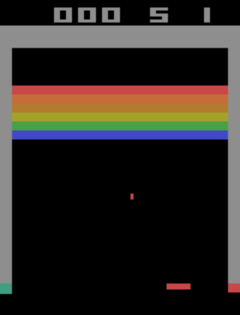

In [ ]:
bsm= create_gif(fs_test, beststoredmodel, max_steps=2000, seed=20, folder='gifs', filename='beststoredmodel', scale = 1.5, fps=40)